!pip install pyodbc

In [1]:
import pyodbc
import configparser
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
import os
from matplotlib.lines import Line2D

In [2]:
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Remplacez 4 par le nombre de cœurs de votre machine

### Connection à SQL Server et Extraction des données

**Connection**

In [3]:
!ping 192.168.119.2


Envoi d'une requ�te 'Ping'  192.168.119.2 avec 32 octets de donn�es�:
R�ponse de 192.168.119.2�: octets=32 temps<1ms TTL=128
R�ponse de 192.168.119.2�: octets=32 temps<1ms TTL=128
R�ponse de 192.168.119.2�: octets=32 temps<1ms TTL=128
R�ponse de 192.168.119.2�: octets=32 temps<1ms TTL=128

Statistiques Ping pour 192.168.119.2:
    Paquets�: envoy�s = 4, re�us = 4, perdus = 0 (perte 0%),
Dur�e approximative des boucles en millisecondes :
    Minimum = 0ms, Maximum = 0ms, Moyenne = 0ms


In [4]:
print(f"Driver: {pyodbc.drivers()}")
conf_path = '../configurations/db.cfg'
print("Fichier trouvé :", os.path.exists(conf_path))

Driver: ['SQL Server', 'SQL Anywhere 17']
Fichier trouvé : True


In [5]:
try:
    config = configparser.ConfigParser()
    config.read(conf_path)

    print("Sections trouvées :", config.sections())

    if 'database' not in config:
        raise Exception("Section [database] manquante dans db.cfg")

    db = config['database']
    conn_str = (
        f"DRIVER={{{db['DRIVER']}}};"
        f"SERVER={db['SERVER']};"
        f"UID={db['UID']};"
        f"PWD={db['PWD']};"
        f"DATABASE={db['DATABASE']};"
    )

    conn = pyodbc.connect(conn_str)
    print("Connexion réussie.")
except Exception as e:
    print("Erreur lors de la connexion à la base de données :", e)
""" finally:
    if 'conn' in locals():
        conn.close()
        print("Connexion fermée.") """


Sections trouvées : ['database']
Connexion réussie.


' finally:\n    if \'conn\' in locals():\n        conn.close()\n        print("Connexion fermée.") '

**Importation des données**

In [179]:
# Récupération des données dans une DataFrame
def get_data(query):
    conn = pyodbc.connect(conn_str)
    df = pd.read_sql(query, conn)
    conn.close()
    return df

df = get_data("SELECT TOP 100 PERCENT * FROM [inFlow].[dbo].[VIEW_Mouvement]")

C:\Users\herif\AppData\Local\Temp\ipykernel_17972\3030561299.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [186]:
df.head(3)

,InventoryLogDetailId,BatchType,Remarks,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId,PerDate,UnitPrice
0,100,6,PO-000001,2019-08-08 01:36:28.523,80.0,NaN,100.0,NaN,NaN,0.0,80.0,ZINNIA-F CP ENR B/3*28 FAMY CARE LTD,4968,,14200.0
1,101,6,PO-000001,2019-08-08 01:36:28.523,12.0,NaN,100.0,NaN,NaN,0.0,12.0,ZINNIA-F CP ENR DET PL/28 FAMY CARE LTD,4969,2510,4800.0
2,102,6,PO-000006,2019-08-08 14:56:17.520,2.0,NaN,100.0,NaN,NaN,0.0,2.0,"ALLERGODIL 0,127MG/DOSE SPRAY NASAL FL/17ML MYLAN",221,2509,27100.0


In [ ]:
df.shape

(837703, 15)

### Filtrage des données

**Récupérer les mouvements des Produits à péremption obligatoire**

In [ ]:
# Filtrez les données dont 'PerDate' est différent de ""
df['PerDate'] = df['PerDate'].astype(str).str.strip()

In [ ]:
# Filtrer les lignes où 'PerDate' n'est pas vide
df_PO = df.copy()
df_PO = df_PO[df_PO['PerDate'] != ""]
df_PO.reset_index(drop=True, inplace=True)
print(df_PO.shape)

(535721, 15)


**Traitement des colonnes et des valeurs nulles**

In [ ]:
df_PO.isnull().sum()

InventoryLogDetailId         0
BatchType                    0
Remarks                      0
TransactionDate              0
Quantity                     0
FromLocationId          111153
ToLocationId             20634
FromQuantityBefore      111153
FromQuantityAfter       111153
ToQuantityBefore         20634
ToQuantityAfter          20634
Name                         0
ProdId                       0
PerDate                      0
UnitPrice                 1233
dtype: int64

In [ ]:
def fill_columns(row):
    # Cas où BatchType n'est pas pris en charge explicitement
    if row['BatchType'] not in [1, 3, 5, 6]:
        row['LastStock'] = 0
        row['CurrentStock'] = 0
        return row

    # Cas où l'on doit inverser la quantité et prendre les valeurs "From"
    if (row['BatchType'] in [1, 5, 6] and not np.isnan(row['FromLocationId'])) or row['BatchType'] == 3:
        row['Quantity'] *= -1
        row['LastStock'] = row['FromQuantityBefore']
        row['CurrentStock'] = row['FromQuantityAfter']
        return row

    # Cas où l'on prend les valeurs "To"
    if row['BatchType'] in [1, 5, 6] and np.isnan(row['FromLocationId']):
        row['LastStock'] = row['ToQuantityBefore']
        row['CurrentStock'] = row['ToQuantityAfter']
        return row

    # Sécurité (ne devrait jamais arriver)
    row['LastStock'] = 0
    row['CurrentStock'] = 0
    return row

In [ ]:
# Create the two new columns and apply the function to each row
df_PO['LastStock'] = 0
df_PO['CurrentStock'] = 0
df_PO = df_PO.apply(fill_columns, axis=1)

# Supprimer les colonnes inutiles
df_PO.drop(columns = ['InventoryLogDetailId', 'FromLocationId', 'ToLocationId', 'FromQuantityBefore', 'FromQuantityAfter', 'ToQuantityBefore', 'ToQuantityAfter'], inplace=True)

df_PO.head()

,BatchType,Remarks,TransactionDate,Quantity,Name,ProdId,PerDate,UnitPrice,LastStock,CurrentStock
0,6,PO-000001,2019-08-08 01:36:28.523,12.0,ZINNIA-F CP ENR DET PL/28 FAMY CARE LTD,4969,2510,4800.0,0.0,12.0
1,6,PO-000006,2019-08-08 14:56:17.520,2.0,"ALLERGODIL 0,127MG/DOSE SPRAY NASAL FL/17ML MYLAN",221,2509,27100.0,0.0,2.0
2,6,PO-000006,2019-08-08 14:56:17.520,1.0,CARVEDI-DENK 25MG CP B/30 DENK PHARMA,1062,2605/2701,46700.0,0.0,1.0
3,6,PO-000006,2019-08-08 14:56:17.520,3.0,DICLO DENK 100MG SUPPO B/10 DENK PHARMA,1476,2511,18300.0,0.0,3.0
4,6,PO-000006,2019-08-08 14:56:17.520,1.0,"FLOXSOL 0,3% COLLYRE FL/5ML EXPHAR",1964,2508,6700.0,0.0,1.0


In [ ]:
print(df_PO.isnull().sum())

BatchType             0
Remarks               0
TransactionDate       0
Quantity              0
Name                  0
ProdId                0
PerDate               0
UnitPrice          1233
LastStock             0
CurrentStock          0
dtype: int64


In [ ]:
df_PO['UnitPrice'] = df_PO['UnitPrice'].fillna(df_PO['UnitPrice'].mean(numeric_only=True))

### Analyse Exploratoire des Données

**Aperçu générale des données**

In [ ]:
df_PO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535721 entries, 0 to 535720
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BatchType        535721 non-null  int64         
 1   Remarks          535721 non-null  object        
 2   TransactionDate  535721 non-null  datetime64[ns]
 3   Quantity         535721 non-null  float64       
 4   Name             535721 non-null  object        
 5   ProdId           535721 non-null  int64         
 6   PerDate          535721 non-null  object        
 7   UnitPrice        535721 non-null  float64       
 8   LastStock        535721 non-null  float64       
 9   CurrentStock     535721 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 40.9+ MB


In [ ]:
df_PO.describe()

,BatchType,TransactionDate,Quantity,ProdId,UnitPrice,LastStock,CurrentStock
count,535721.000000,535721,535721.000000,535721.000000,535721.000000,535721.000000,535721.000000
mean,3.707895,2022-11-01 22:03:56.307156736,0.007709,2939.174007,21058.405801,18.176876,18.184585
min,1.000000,2012-11-23 12:36:39.660000,-1010.000000,100.000000,200.000000,-338.000000,-338.000000
25%,3.000000,2021-08-07 16:46:37.987000064,-1.000000,1463.000000,5400.000000,2.000000,2.000000
50%,3.000000,2022-12-25 09:14:21.689999872,-1.000000,2811.000000,13900.000000,5.000000,5.000000
75%,3.000000,2024-02-19 17:46:04.196999936,-1.000000,4340.000000,29200.000000,15.000000,15.000000
max,6.000000,2025-04-06 16:43:37.327000,2500.000000,7771.000000,782000.000000,2403.000000,2403.000000
std,1.297156,NaN,11.005915,1845.358903,24908.854015,52.693513,52.701619


**Analyse des différentes types de mouvements**

In [ ]:
batch_type_map = {
    1: 'Ajustement',
    3: 'Assortiment',
    5: 'Réapprovisionnement',
    6: 'Reception',
}

batch = df_PO.copy()
batch = (
    batch.groupby('BatchType').agg(
        HeadCount = ('BatchType', 'count'),
        Quantity = ('Quantity', lambda x: x.abs().sum()),
        #Amount = ('Amount', 'sum')
    ).reset_index(
        ).replace({'BatchType': batch_type_map})
)
batch['HCPercent'] = batch['HeadCount'] / batch['HeadCount'].sum() * 100
batch['QtyPercent'] = batch['Quantity'] / batch['Quantity'].sum() * 100

batch.sort_values(by='HeadCount', ascending=False, inplace=True)
batch

,BatchType,HeadCount,Quantity,HCPercent,QtyPercent
1,Assortiment,403934,618435.0,75.400068,39.965556
3,Reception,128544,911274.0,23.994579,58.889894
0,Ajustement,3221,17681.0,0.601246,1.142612
2,Réapprovisionnement,22,30.0,0.004107,0.001939


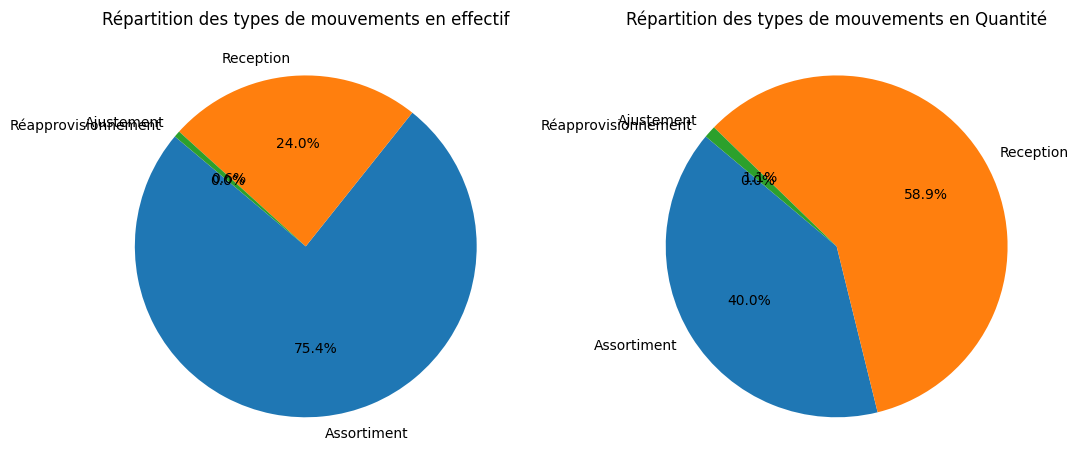

In [189]:
fig, ax = plt.subplots(1, 2, figsize=(11, 6))
ax[0].pie(batch['HCPercent'], labels=batch['BatchType'], autopct='%1.1f%%', startangle=140)
ax[0].set_title('Répartition des types de mouvements en effectif')
ax[1].pie(batch['QtyPercent'], labels=batch['BatchType'], autopct='%1.1f%%', startangle=140)
ax[1].set_title('Répartition des types de mouvements en Quantité')

plt.tight_layout()
plt.show()

#### **Analyse par produit**

**Approche 1 : Analyse des variations de quantité par rapport aux nombres de mouvements**

In [ ]:
P0 = df_PO.copy()
P0 = (
    P0.groupby('ProdId').agg(
        Moves = ('ProdId', 'count'),
        Quantity = ('Quantity', 'mean')
    ).reset_index()
)

In [ ]:
P0.head()

,ProdId,Moves,Quantity
0,100,77,0.025974
1,102,12,0.000000
2,106,13,0.000000
3,113,360,0.011111
4,115,52,0.019231


In [ ]:
P0[['Moves', 'Quantity']].describe()

,Moves,Quantity
count,2038.000000,2038.000000
mean,262.866045,0.035239
std,488.759703,0.271270
min,1.000000,-5.478261
25%,40.000000,0.000000
50%,129.000000,0.008999
75%,295.000000,0.029165
max,7578.000000,4.000000


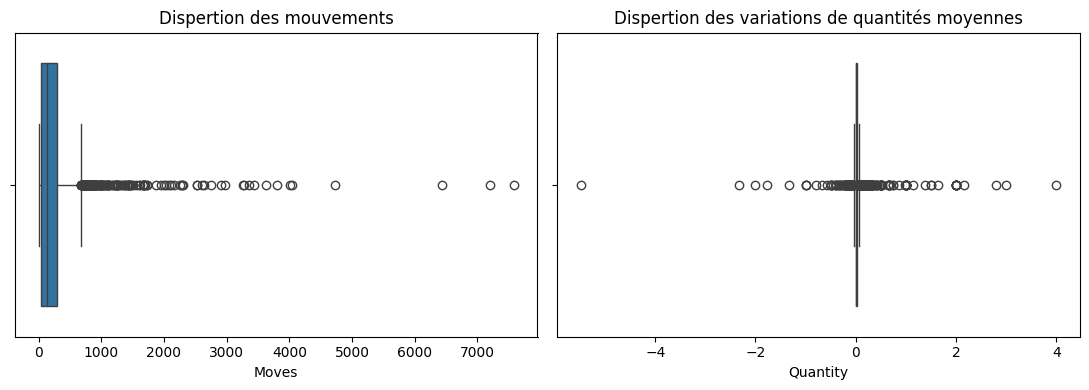

In [198]:
# Boxplot des mouvements et des quantités
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

sns.boxplot(x='Moves', data=P0, ax=ax[0])
sns.boxplot(x='Quantity', data=P0, ax=ax[1])

ax[0].set_title('Dispertion des mouvements')
ax[1].set_title('Dispertion des variations de quantités moyennes')
plt.tight_layout()
plt.show()

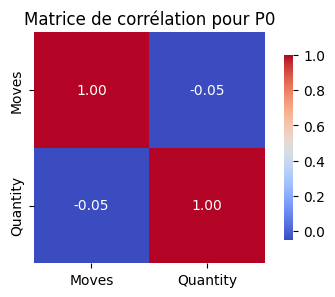

In [ ]:
corr_p0 = P0[['Moves', 'Quantity']].corr()
plt.figure(figsize=(5, 3))
sns.heatmap(corr_p0, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Matrice de corrélation pour P0')
plt.show()

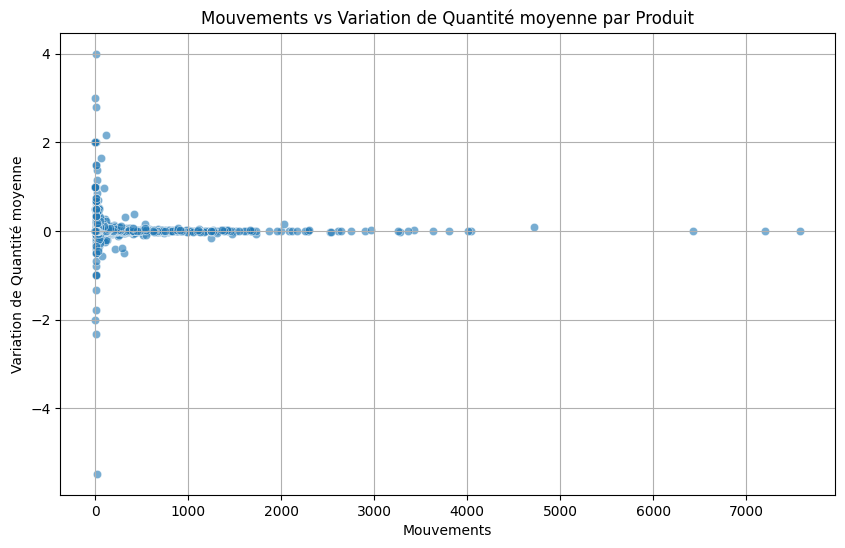

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=P0, x='Moves', y='Quantity', alpha=0.6)
plt.title('Mouvements vs Variation de Quantité moyenne par Produit')
plt.xlabel('Mouvements')
plt.ylabel('Variation de Quantité moyenne')
plt.grid()
plt.show()

**Approche 2 : Analyse par produits prenant en compte l'étas du stock et l'impact des prix de vente des produits**

*Grouper les données par produits*

In [ ]:
P1 = df_PO.copy()

P1 = (
    P1.groupby(['ProdId', 'Name']).agg(
        Moves = ('ProdId', 'count'),
        QtIn = ('Quantity', lambda x: x[x > 0].sum()),
        QtOut = ('Quantity', lambda x: -x[x < 0].sum()),
        StockAVG = ('LastStock', 'mean'),
        UnitPrice = ('UnitPrice', 'mean'),
    ).reset_index()
)

In [ ]:
P1.head()

,ProdId,Name,Moves,QtIn,QtOut,StockAVG,UnitPrice
0,100,MULTIVITAMINES GLOBAL 12 VIT+ 7 OLIGO ELEMENTS...,77,49.0,47.0,1.272727,33800.0
1,102,804 AIDE MINCEUR TRIPLE ACTION CP B/30 3CHENE,12,6.0,6.0,0.500000,61500.0
2,106,A 313 50000U CAPS B/30,13,8.0,8.0,0.846154,20800.0
3,113,ACARILBIAL 277MG/ML SOL CUT FL/200ML BIAL,360,273.0,269.0,3.147222,19100.0
4,115,ACCU CHEK ACTIVE BANDELETTE B/50,52,28.0,27.0,0.576923,92900.0


In [ ]:
P1[['Moves', 'QtIn', 'QtOut', 'StockAVG', 'UnitPrice']].describe()

,Moves,QtIn,QtOut,StockAVG,UnitPrice
count,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000
mean,262.866045,380.655054,378.628557,4.917013,32763.057630
std,488.759703,1183.374358,1183.172689,12.457151,41307.459552
min,1.000000,0.000000,-0.000000,-50.152482,200.000000
25%,40.000000,30.000000,27.250000,1.098149,10025.000000
50%,129.000000,106.000000,104.500000,2.052294,20800.000000
75%,295.000000,303.500000,303.750000,4.327022,40500.000000
max,7578.000000,25862.000000,25885.000000,288.034084,782000.000000


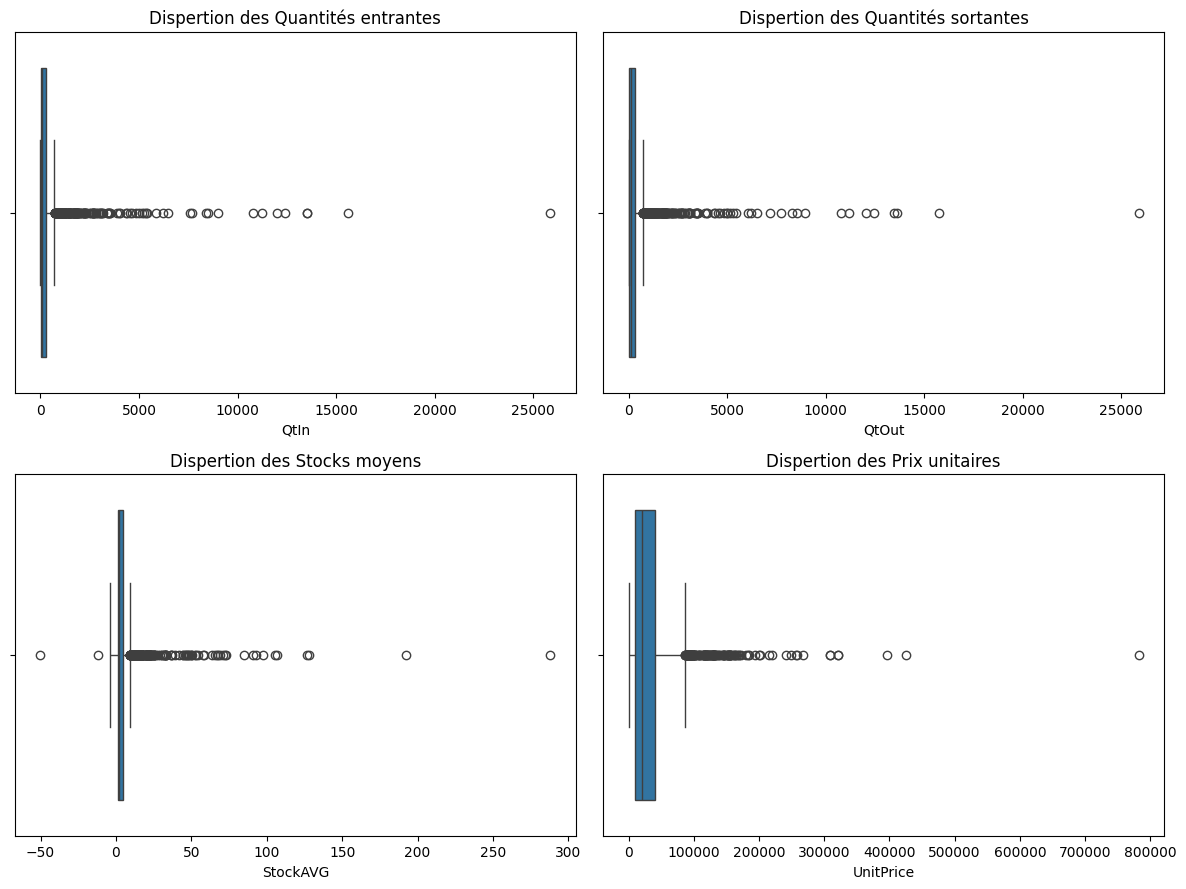

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
sns.boxplot(x='QtIn', data = P1, ax = ax[0][0])
sns.boxplot(x='QtOut', data = P1, ax = ax[0][1])
sns.boxplot(x='StockAVG', data = P1, ax = ax[1][0])
sns.boxplot(x='UnitPrice', data = P1, ax = ax[1][1])
ax[0][0].set_title('Dispertion des Quantités entrantes')
ax[0][1].set_title('Dispertion des Quantités sortantes')
ax[1][0].set_title('Dispertion des Stocks moyens')
ax[1][1].set_title('Dispertion des Prix unitaires')
plt.tight_layout()
plt.show()

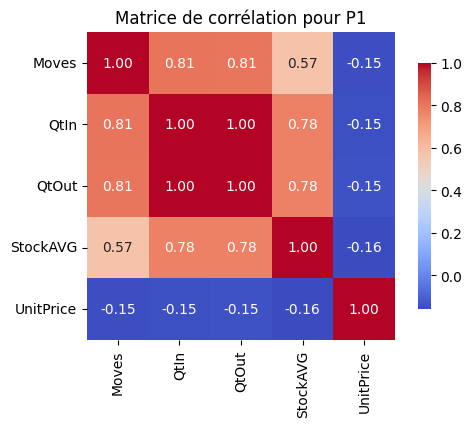

In [ ]:
corr_p1 = P1[['Moves', 'QtIn', 'QtOut', 'StockAVG', 'UnitPrice']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_p1, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matrice de corrélation pour P1')
plt.show()

*Traitement des valeurs nulles et/ou infinis après le calcul du turnover*

In [ ]:
print(P1.isna().sum())


ProdId       0
Name         0
Moves        0
QtIn         0
QtOut        0
StockAVG     0
UnitPrice    0
dtype: int64


In [ ]:
P1['UnitPrice'] = P1['UnitPrice'].fillna(P1['UnitPrice'].mean(numeric_only=True))

In [ ]:
quant_columns = ['Moves', 'QtIn', 'QtOut', 'StockAVG', 'UnitPrice']
P1[quant_columns].describe()

,Moves,QtIn,QtOut,StockAVG,UnitPrice
count,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000
mean,262.866045,380.655054,378.628557,4.917013,32763.057630
std,488.759703,1183.374358,1183.172689,12.457151,41307.459552
min,1.000000,0.000000,-0.000000,-50.152482,200.000000
25%,40.000000,30.000000,27.250000,1.098149,10025.000000
50%,129.000000,106.000000,104.500000,2.052294,20800.000000
75%,295.000000,303.500000,303.750000,4.327022,40500.000000
max,7578.000000,25862.000000,25885.000000,288.034084,782000.000000


*Calcule des correlation entre les variables*

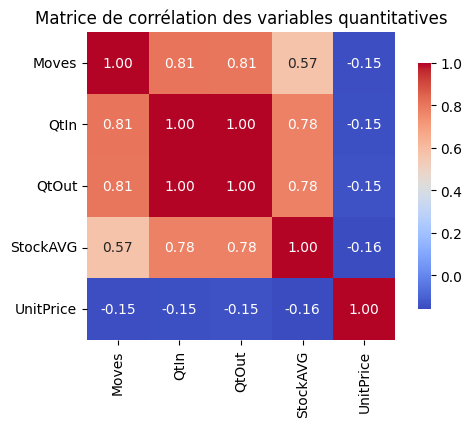

In [ ]:
corr = P1[quant_columns].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matrice de corrélation des variables quantitatives')
plt.show()

### Analyse en composantes principales (PCA) pour la sélection des variables

*Normalisation des données*

In [ ]:
X = P1[quant_columns].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

*Visualisation des données*

In [ ]:
df_scaled = pd.DataFrame(X_scaled, columns=quant_columns)
df_scaled.head()

,Moves,QtIn,QtOut,StockAVG,UnitPrice
0,-0.380374,-0.280331,-0.280356,-0.292617,0.025109
1,-0.513397,-0.316677,-0.315017,-0.354664,0.695855
2,-0.511350,-0.314986,-0.313327,-0.326869,-0.289681
3,0.198784,-0.090995,-0.092679,-0.142105,-0.330846
4,-0.431537,-0.298081,-0.297264,-0.348487,1.456195


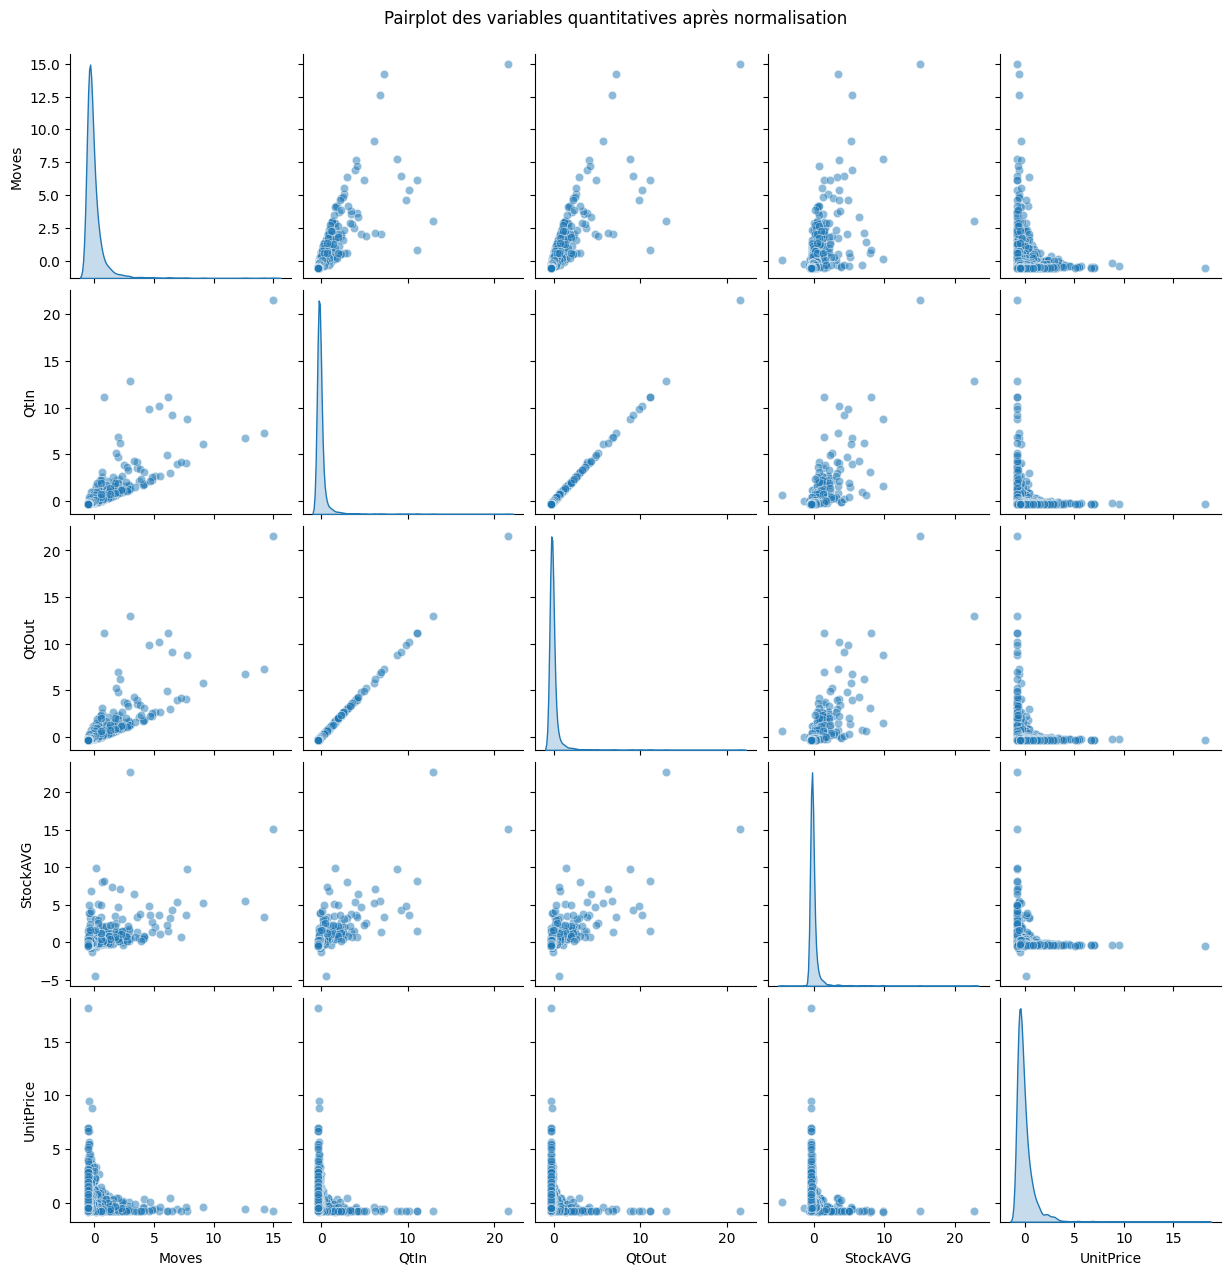

In [ ]:
sns.pairplot(df_scaled, diag_kind='kde', markers='o', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot des variables quantitatives après normalisation', y=1.02)
plt.show()

In [ ]:
pca = PCA(n_components=5)
pca.fit(X_scaled)

PCA(n_components=5)

In [200]:
print(pca)

PCA(n_components=5)


In [ ]:
np.cumsum(pca.explained_variance_ratio_)

array([0.68401   , 0.87682448, 0.96253529, 0.99997953, 1.        ])

Text(0.5, 1.0, 'Variance expliquée cumulée par les composantes principales')

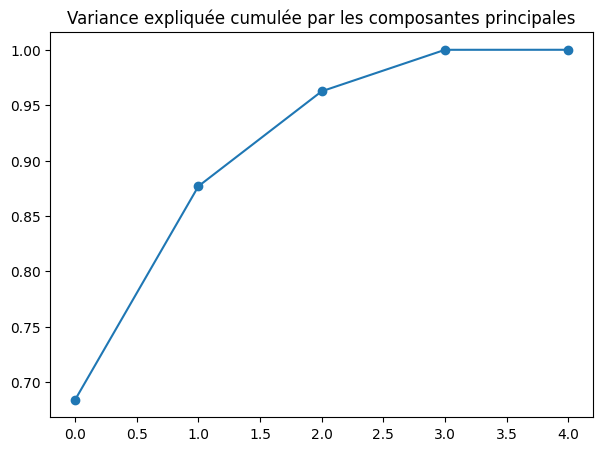

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Variance expliquée cumulée par les composantes principales')

In [ ]:
info_retained = 0.95
ncomponents = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= info_retained) + 1
print(f"Nombre de composantes pour conserver {info_retained*100}% de l'information : {ncomponents}")

Nombre de composantes pour conserver 95.0% de l'information : 3


In [ ]:
pca2 = PCA(n_components=ncomponents)
X_pca = pca2.fit_transform(X_scaled)

In [204]:
print(pca2)

PCA(n_components=3)


In [ ]:
P1['PC1'] = X_pca[:, 0]
P1['PC2'] = X_pca[:, 1]
P1['PC3'] = X_pca[:, 2]

In [202]:
P1.head()

,ProdId,Name,Moves,QtIn,QtOut,StockAVG,UnitPrice,PC1,PC2,PC3,KM1_Cluster
0,100,MULTIVITAMINES GLOBAL 12 VIT+ 7 OLIGO ELEMENTS...,77,49.0,47.0,1.272727,33800.0,-0.610674,-0.047406,0.048643,0
1,102,804 AIDE MINCEUR TRIPLE ACTION CP B/30 3CHENE,12,6.0,6.0,0.500000,61500.0,-0.821261,0.603866,0.103355,0
2,106,A 313 50000U CAPS B/30,13,8.0,8.0,0.846154,20800.0,-0.684532,-0.372234,0.105715,0
3,113,ACARILBIAL 277MG/ML SOL CUT FL/200ML BIAL,360,273.0,269.0,3.147222,19100.0,-0.028256,-0.337673,-0.237280,0
4,115,ACCU CHEK ACTIVE BANDELETTE B/50,52,28.0,27.0,0.576923,92900.0,-0.854543,1.364822,0.066194,0


*Visualisation par rapport à la 1ère et 2ème composante principale*

In [ ]:
print(pca2.components_)

[[ 0.46758098  0.52806924  0.52756972  0.4572061  -0.12305967]
 [ 0.04712482  0.08343747  0.0838389   0.02557104  0.99153144]
 [-0.65727244 -0.03260751 -0.03252418  0.75204473  0.01733758]]


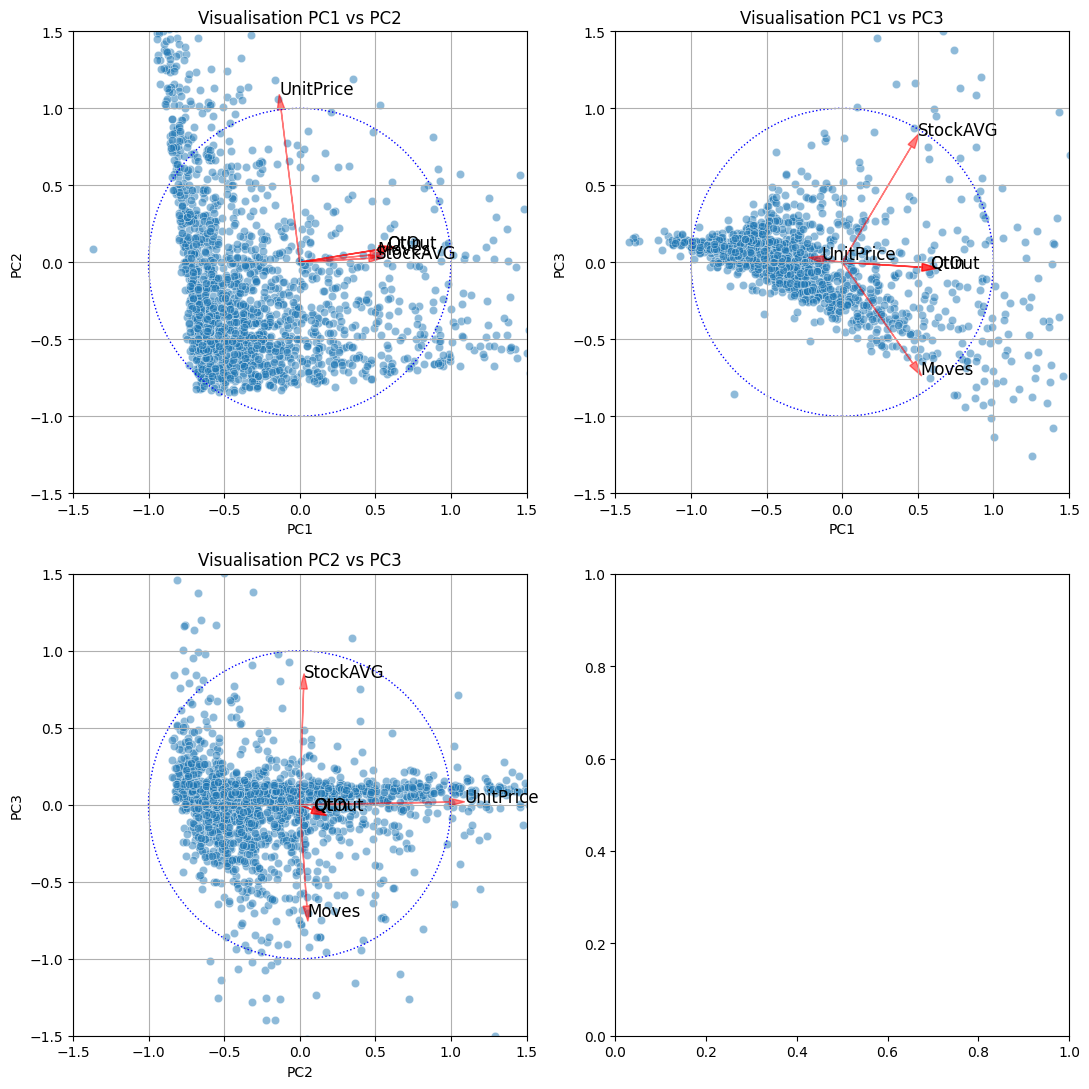

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(11, 11))

combinations = [
    ('PC1', 'PC2', 0, 1),
    ('PC1', 'PC3', 0, 2),
    ('PC2', 'PC3', 1, 2)
]

for ax, (x, y, i, j) in zip(axes.flat, combinations):
    sns.scatterplot(data=P1, x=x, y=y, alpha=0.5, ax=ax)
    ax.set_title(f'Visualisation {x} vs {y}')
    for k, var in enumerate(quant_columns):
        ax.arrow(
            0, 0, pca2.components_[i, k], pca2.components_[j, k],
            color='r', alpha=0.5, head_width=0.05, head_length=0.1
        )
        ax.text(
            pca2.components_[i, k] * 1.1, pca2.components_[j, k] * 1.1,
            var, color='black', fontsize=12
        )
    circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='dotted')
    ax.add_artist(circle)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.grid()

plt.tight_layout()
plt.show()

D'après ces visualisations, on peut dire que les impacts de chaque variables pour chaque composante principale sont significatifs.
'Moves'(nombre de mouvement)

- PC1 est fortement influencée par 'QtIn'(Quantité entrante) et 'QtOut' (Quantité sortante). On remarque aussi un impact plus ou moin important de 'Move' (nombre de mouvement). Donc cette composante reflète  l'**Intensité logistique**. Cette décalage de la variable 'Move' par rapport à 'QtIn' et 'QtOut' est justifiée par les deux résultats très différent en pourcentage en effectif et quantité : 
En effectif il y a 75 % d'assortiments et 24 % de réceptions, alors qu'en terme de quantité, il y a 58.9 % de réceptions et 40 % d'assortiments.

Cela est du au faite que les achats sont moins fréquents que les ventes et ont plus de quantité.

- PC2 est fortement influencée par 'UnitPrice' (Prix Unitaire). Le faite que 'UnitPrice' impacte la 2ème composante principale, on peut dire que cette composante est liée à la **Valeur monétaire** des produits. On constate que les produits avec un prix unitaire élevé ont tendance à avoir moins de mouvements, ce qui est logique car les produits chers sont généralement moins achetés. PC2 sera plus pertinente pour optimiser les coûts d'achat. Mais en terme d'inventaire, ces produits risques aussi de rester longtemps en stock et donc d'être périmés. Mais ils sont minoritaires en terme de quantité des produits périmés.

- PC3 est fortement influencée par 'StockAVG' (Quantité en Stock moyenne). Le décalage de 'StockAVG' par rapport à 'QtIn' et 'QtOut' signifie que même s'il y a une parfaite équilibre entre les entrées et les sorties de produits (très forte correlation entre 'QtIn' et 'QtOut'), il y a toujours une quantité moyenne de produits en stock. Cela peut être dû à l'approvisionnement pour certains produits afin de garantir un disponibilité continue, ou à des produits qui sont moins demandés et disponible en stock plus longtemps. Ce dernier cas présente un risque de péremption pour les produits à péremption obligatoire.

- La symétrie entre les vecteurs des 3 variables 'QtIn', 'QtOut' et 'StockAVG' et les corrélation assez élevées de 0.81 pour 'QtIn'-'Moves' et 0.77 pour 'QtOut'-'StockAVG' signifie qu'on peut introduire des nouvelles indicateurs pour mieux cibler les produits à faible rotation et à risque de péremption.

### Préparation des données et des paramètre pour la modélisation

*Préparation des données*

In [ ]:
TrainData = P1[['PC1', 'PC2', 'PC3']].copy()

TrainData.head()

,PC1,PC2,PC3
0,-0.610674,-0.047406,0.048643
1,-0.821261,0.603866,0.103355
2,-0.684532,-0.372234,0.105715
3,-0.028256,-0.337673,-0.237280
4,-0.854543,1.364822,0.066194


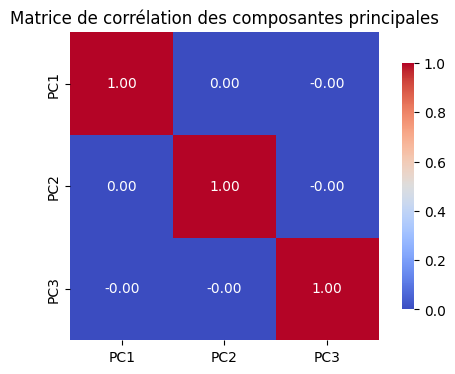

In [ ]:
corr_PCA = TrainData.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_PCA, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matrice de corrélation des composantes principales')
plt.show()

#### **Méthode de Elbow pour déterminer le nombre de clusters**

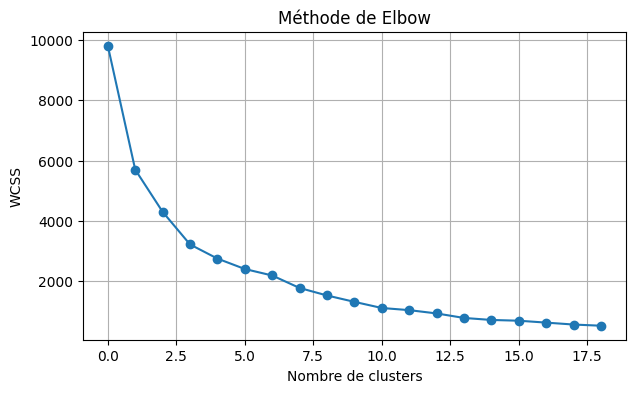

In [ ]:
wcss = []

for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(TrainData)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(wcss, marker='o')
plt.title('Méthode de Elbow')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


D'aprèse ce résultat, notre coude est moins flexible mais on peut dire qu'il est entre 3 et 4. Donc on va essayer avec 3 et 4 clusters pour notre algorithme de clustering.

### Apprentissage Automatique : Classification non supervisée

Pour la première approche, on va entrainer notre modèle K-Means sur les 3 premières composantes principales.

#### **K-Means 1** (entrainement sur les composantes principales)

In [203]:
KM1 = KMeans(n_clusters=3, random_state=42)
P1['KM1_Cluster'] = KM1.fit_predict(TrainData)

print(KM1)
print(P1['KM1_Cluster'].value_counts())

print("Silhouette Score:", silhouette_score(TrainData, P1['KM1_Cluster']))

KMeans(n_clusters=3, random_state=42)
KM1_Cluster
0    1928
2      99
1      11
Name: count, dtype: int64
Silhouette Score: 0.7261543947160739


La Silhouette est une mesure de la qualité de la séparation des clusters. Elle varie entre -1 et 1, où une valeur proche de 1 indique que les points sont bien regroupés dans leur cluster, tandis qu'une valeur proche de -1 indique que les points sont mal regroupés.
Une Slihouette Score de 0.58 indique une séparation raisonnable des clusters, mais il y a encore de la place pour améliorer la séparation.

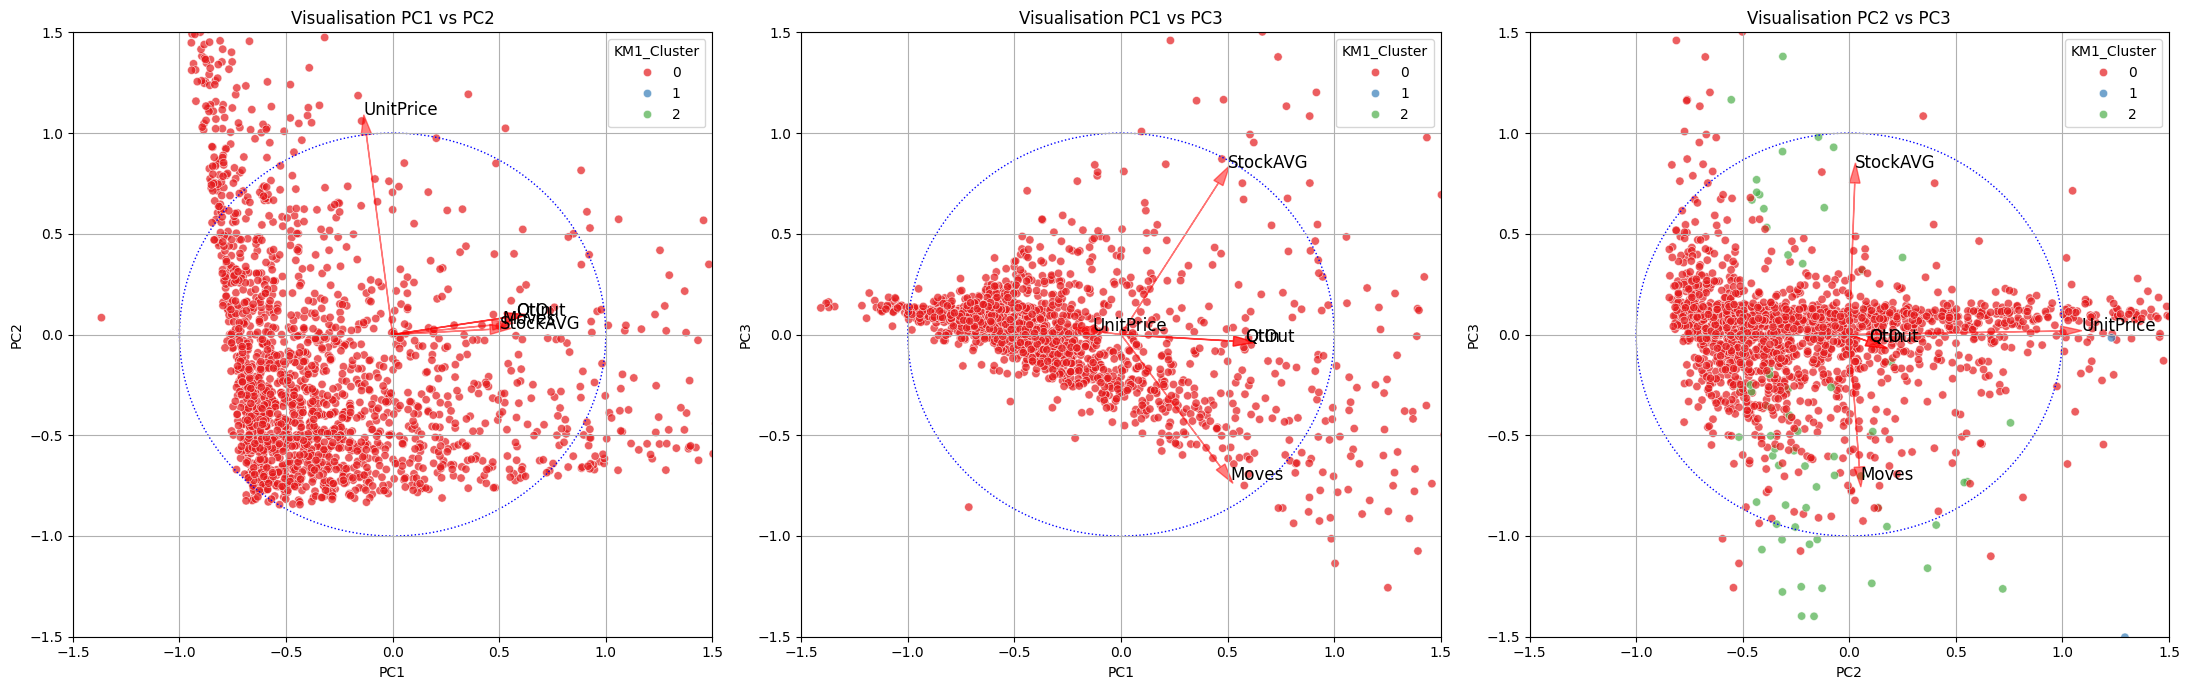

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

combinations = [
    ('PC1', 'PC2', 0, 1),
    ('PC1', 'PC3', 0, 2),
    ('PC2', 'PC3', 1, 2)
]

for ax, (x, y, i, j) in zip(axes, combinations):
    sns.scatterplot(data=P1, x=x, y=y,hue = P1['KM1_Cluster'], palette = 'Set1', alpha=0.7, ax=ax)
    ax.set_title(f'Visualisation {x} vs {y}')
    for k, var in enumerate(quant_columns):
        ax.arrow(
            0, 0, pca2.components_[i, k], pca2.components_[j, k],
            color='r', alpha=0.5, head_width=0.05, head_length=0.1
        )
        ax.text(
            pca2.components_[i, k] * 1.1, pca2.components_[j, k] * 1.1,
            var, color='black', fontsize=12
        )
    circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='dotted')
    ax.add_artist(circle)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.grid()

plt.tight_layout()
plt.show()

In [ ]:
centroids = KM1.cluster_centers_
print(centroids)

[[-3.12711428e-01 -5.67281597e-03  1.38925673e-02]
 [ 1.82072919e+01  1.61667155e+00 -2.01291067e-02]
 [ 4.06694365e+00 -6.91535138e-02 -2.68317672e-01]]


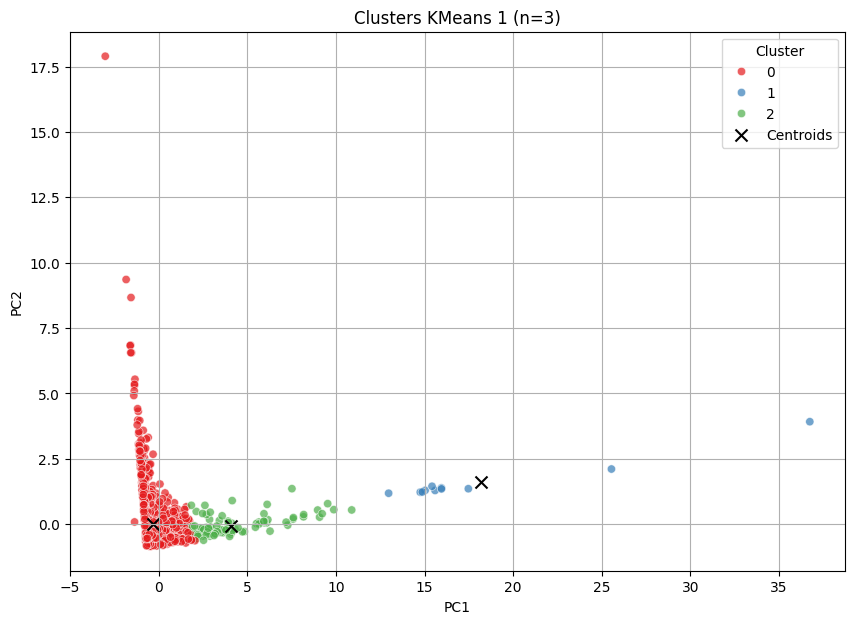

In [ ]:
plt.figure(figsize=(10, 7))

sns.scatterplot(data=P1, x='PC1', y='PC2', hue='KM1_Cluster', palette='Set1', alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], s=75, c='black', marker='x', label='Centroids')

plt.title('Clusters KMeans 1 (n=3)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

Notre modèle parvient à détecter les produits à grande valeur monétaire qui ont peut de mouvements qui sont les clusters 3 (violet)

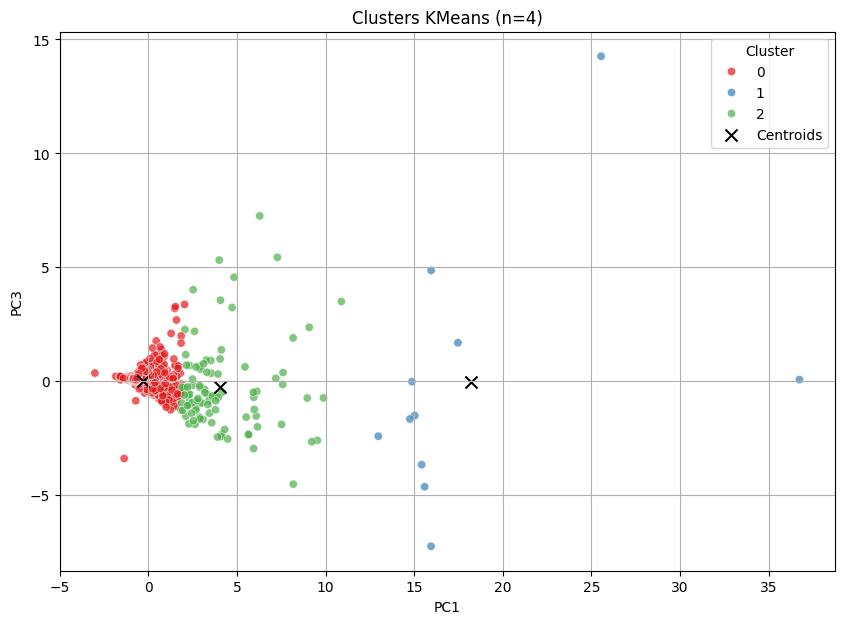

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=P1, x='PC1', y='PC3', hue='KM1_Cluster', palette='Set1', alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 2], s=75, c='black', marker='x', label='Centroids')

plt.title('Clusters KMeans (n=4)')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

Cette visualisation montre une classification des produits généralement en fonction de leur intensité d'approvisionnement (cluster 0 : faible, cluster 1 : moyenne, cluster 2 : forte) mais ne parvient pas à distinguer parmis cette ensemble ceux qui ont de faible rotation (les moins vendus).

Cela est du au fait que PC1 est influencée en même temps par 'QtIn' (quantité total reçue), 'QtOut' (quantité total assortie) et une partie de 'Move' (nombre de mouvement), ce qui rend difficile la séparation des produits à faible rotation et à fort taux d'approvisionnement.

De plus cela montre l'inconvénient des ACP car les composantes qui sont des combinaisons linéaires de variables d'origine sont difficiles à interpréter.

Ce résultat nous amène à introduire des indicateurs essentiels pour mieux cibles ces produits à grande risque de surstock.

De plus la symétrie qu'on a constété précédement entre les vecteurs des 3 variables 'QtIn', 'QtOut' et 'StockAVG' et leurs corrélations assez élevées de 0.81 pour 'QtIn'-'Moves' et 0.77 pour 'QtOut'-'StockAVG'nous justifie réduire ces 3 variables en deux dont l'un sera en fonction de 'StockAVG' et l'autre en fonction de 'Moves'.

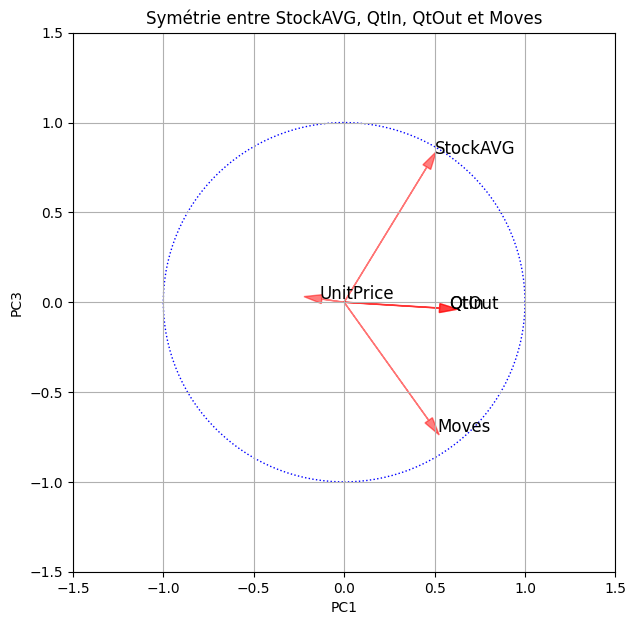

In [ ]:
plt.figure(figsize=(7, 7))
for k, var in enumerate(quant_columns):
    plt.arrow(0, 0, pca2.components_[0, k], pca2.components_[2, k], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
    plt.text(pca2.components_[0, k] * 1.1, pca2.components_[2, k] * 1.1, var, color='black', fontsize=12)
circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='dotted')
plt.gca().add_artist(circle)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.title('Symétrie entre StockAVG, QtIn, QtOut et Moves')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.grid()
plt.show()

#### **K-Means 2** (entrainement sur les variables d'origine)

**Préparation des données**

*Introduction des nouvelle variables 'Turnover' et 'SupplyRatio'*

Le 'turnover' ou **rotation** est une mesure de la rapidité avec laquelle un produit est vendu et renouvelé dans le stock. Il est calculé comme le ratio entre le **volume de vente** et le **stock moyen**.

 Le 'SupplyRatio' ou **intensité d'approvisionnement** est une mesure du taux sur laquelle un produit est approvisionné. Notre indicateur sera calculé comme le ratio entre la **quantité entrantes**(QtIn) et le **nombre de mouvement**(Moves).

In [ ]:
P2 = P1[['ProdId', 'Name', 'Moves', 'QtIn', 'QtOut', 'StockAVG', 'UnitPrice']].copy()
P2['Turnover'] = P2['QtOut'] / P2['StockAVG']
P2.fillna(0, inplace=True)
P2.replace([np.inf, -np.inf], 0, inplace=True)

P2['SupplyRatio'] = P2['QtIn'] / P2['Moves']

  *Analyse de dispersion des nouvelles variables*

In [ ]:
selected_col = ['UnitPrice', 'Turnover', 'SupplyRatio']
TrainData2 = P2[selected_col]
TrainData2.head()

,UnitPrice,Turnover,SupplyRatio
0,33800.0,36.928571,0.636364
1,61500.0,12.000000,0.500000
2,20800.0,9.454545,0.615385
3,19100.0,85.472198,0.758333
4,92900.0,46.800000,0.538462


In [ ]:
TrainData2.describe()

,UnitPrice,Turnover,SupplyRatio
count,2038.000000,2038.000000,2038.000000
mean,32763.057630,59.343683,1.088709
std,41307.459552,94.910952,1.050142
min,200.000000,-2343.500000,0.000000
25%,10025.000000,21.333333,0.630721
50%,20800.000000,47.898961,0.828888
75%,40500.000000,84.071663,1.083333
max,782000.000000,1449.363636,19.913108


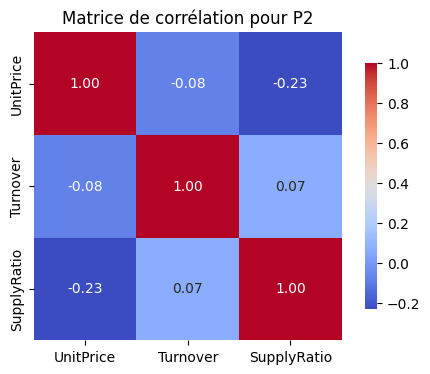

In [ ]:
corr_P2 = TrainData2.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_P2, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matrice de corrélation pour P2')
plt.show()

Après l'introduction des nouvelles variables 'Turnover' et 'SupplyRatio', on remarque les corrélations faibles autour des couples {'UnitPrice','Turnover'} et {'SupplyRatio', 'Turnover'}. La corrélation nagative de -0.23 entre 'SupplyRation' et 'UnitePrice' est inattendue mais c'est acceptable pour l'analyse.

Le résultat n'est pas meilleur que celle des PCA mais l'avantage est que les variables d'origine sont plus faciles à interpréter et à utiliser pour la prise de décision. 

Donc on peut conclure que ces 3 variables sont acceptable pour l'analyse et l'apprentissage.

*Normalisation des données*

In [ ]:
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(TrainData2)

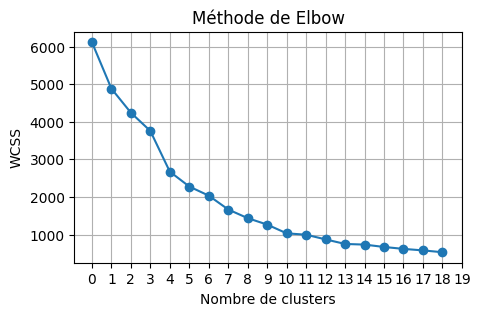

In [ ]:
wcss = []

for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X2_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(5, 3))
plt.plot(wcss, marker='o')
plt.title('Méthode de Elbow')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')
plt.xticks(range(0, 20, 1))
plt.grid(True)
plt.show()

In [205]:
KM2 = KMeans(n_clusters=4, random_state=75)
P2['KM2_Cluster'] = KM2.fit_predict(X2_scaled)
print(KM2)
print(P2['KM2_Cluster'].value_counts())
print("Silhouette Score:", silhouette_score(X2_scaled, P2['KM2_Cluster']))

KMeans(n_clusters=4, random_state=75)
KM2_Cluster
1    1713
3     152
0     122
2      51
Name: count, dtype: int64
Silhouette Score: 0.4983957929346001


In [ ]:
centroids2 = KM2.cluster_centers_
print(centroids)

[[-3.12711428e-01 -5.67281597e-03  1.38925673e-02]
 [ 1.82072919e+01  1.61667155e+00 -2.01291067e-02]
 [ 4.06694365e+00 -6.91535138e-02 -2.68317672e-01]]


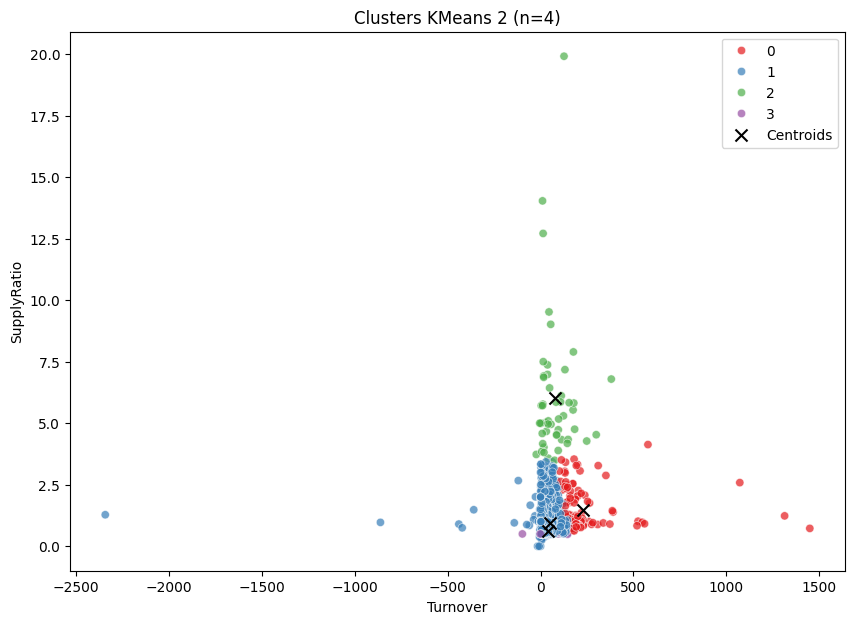

In [ ]:
# Inverser la normalisation pour les colonnes Turnover et SupplyRatio
centroids2_orig = scaler2.inverse_transform(centroids2)

plt.figure(figsize=(10, 7))
sns.scatterplot(data=P2, x='Turnover', y='SupplyRatio', hue='KM2_Cluster', palette='Set1', alpha=0.7)
plt.scatter(centroids2_orig[:, 1], centroids2_orig[:, 2], s=75, c='black', marker='x', label='Centroids')
plt.title('Clusters KMeans 2 (n=4)')
plt.legend()
plt.show()

In [ ]:
P2['SupplyRatio'].mean(), P2['SupplyRatio'].quantile(0.75)

(1.0887089544847324, 1.0833333333333333)

Interprétation des clusters

Cluster 0 (rouge) : Ce sont les produits qui ont les plus fortes rotations (Turnover de 200 à environ 1500) et de ratios d'approvisionnement modérés à cause de leur forte demande. De plus, ils ont des prix unitaires plus bas. Ce sont les produits qui se vendent le plus courament et qui sont donc moins susceptibles de rester trop longtemps en stock. Ce sont ces produits qui sont aussi les plus rentables. Ceux qui ont des rotation ('Turnover') extrêmement élevés (à l'extrême de l'axe) et des niveau de ratio d'approvisionnement faible (inférieur à 1) ont besoin d'une attention particulière pour le maximiser le profit de l'entreprise.  

Cluster 1 (bleu) : Ce sont les produits qui occupent la grande majorité de notre distribution. Ce sont les produits qui ont des rotation plus faibles (Turnover de 0 à environ 200) et de ratios d'approvisionnement plus ou moins modérés (environ entre 0 à 3). On peut aussi dire que c'est la classe qui contient les produits qui ont moins de mouvements entrant aussi que sortant. Ils pourront être des nouveaux produits qui sont en phase de lancement et qui sont moins connus par les patientels ou le contraire, des produits qui sont en voie d'amortissement par rapport à l'évolution du marché. Ils pourraient aussi être des produits qui ont de long délai de péremption.
Les turnover négatifs (à l'extrême de l'axe) sont du à des valeurs de stocks négatives qui sont dues à des erreurs de saisie de commande et aussi de retard de lancement de commande d'achat dans le logiciel. 

Cluster 2 (vert) : Ce sont les produits qui ont des niveaux de ratios d'approvisionnement très élevés de 3 fois la moyenne dont le taux de rotation n'est pas suffisant pour optimiser le stock. Ces produits sont les premiers liste de notre cible car ils ont de risque très élevé de surstock. Les raisons réels pouraient être très variées mais c'est qui est sure est que leurs rotation et approvisionnement sont très déséquilibrés.

Cluster 3 (violet) : Il s'agit du groupe le plus isolé du reste de la distribution. Ce sont les produits qui ont des valeurs monétaires élevées, c'est pour cela que peu de patientels ont les moyens de les acheter. Cependant certains arrivent à atteindre une rotation d'environ 100 et c'est significatif pour des produits qui peut apporter des grand profit à cause de leur valeurs élevées.

In [ ]:
P2[P2['SupplyRatio'] == P2['SupplyRatio'].max()]

,ProdId,Name,Moves,QtIn,QtOut,StockAVG,UnitPrice,Turnover,SupplyRatio,KM2_Cluster
1116,4096,"SALBUTAMOL 0,5MG/1ML SOL INJ AMP DET CIRON DRUGS",679,13521.0,13491.0,106.942563,1200.0,126.15183,19.913108,2


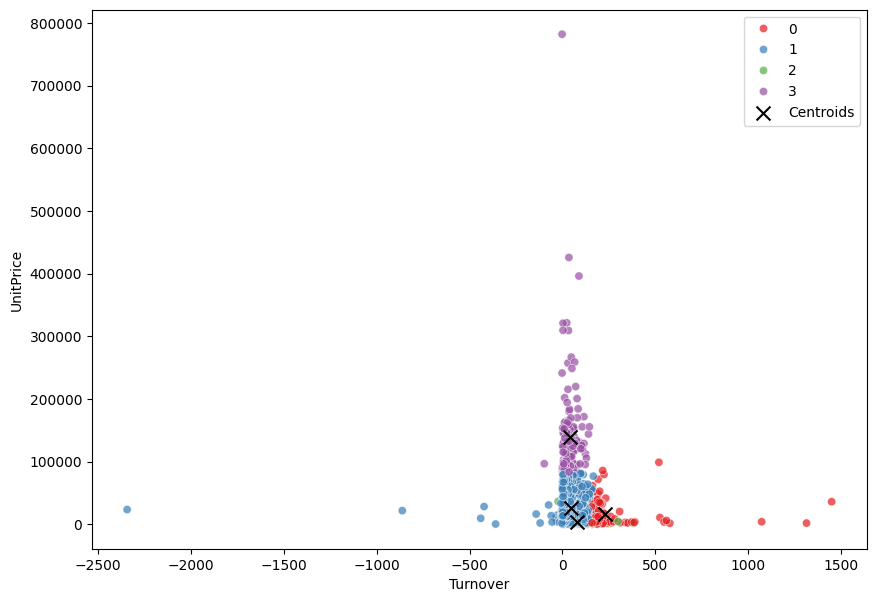

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=P2, x='Turnover', y='UnitPrice', hue='KM2_Cluster', palette='Set1', alpha=0.7)
plt.scatter(centroids2_orig[:, 1], centroids2_orig[:, 0], s=100, c='black', marker='x', label='Centroids')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Clusters KMeans 2 (n=4)')

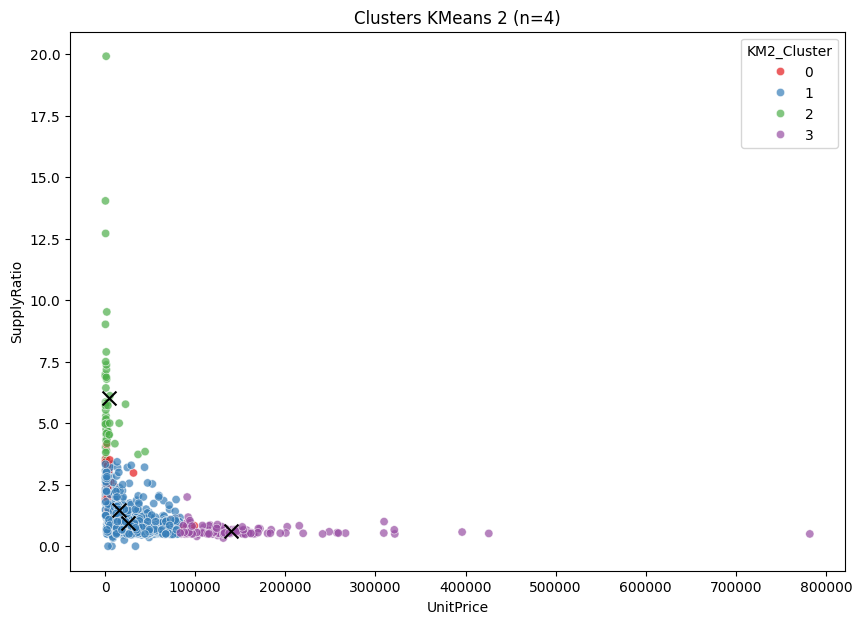

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=P2, x='UnitPrice', y='SupplyRatio', hue='KM2_Cluster', palette='Set1', alpha=0.7)
plt.scatter(centroids2_orig[:, 0], centroids2_orig[:, 2], s=100, c='black', marker='x', label='Centroids')
plt.title('Clusters KMeans 2 (n=4)')

Ici, on peut voir que les produits qui ont les plus haut risques de surstock (Cluster 2 en vert) sont quasiment moin chers.

*Visualisation 3D des résultats*

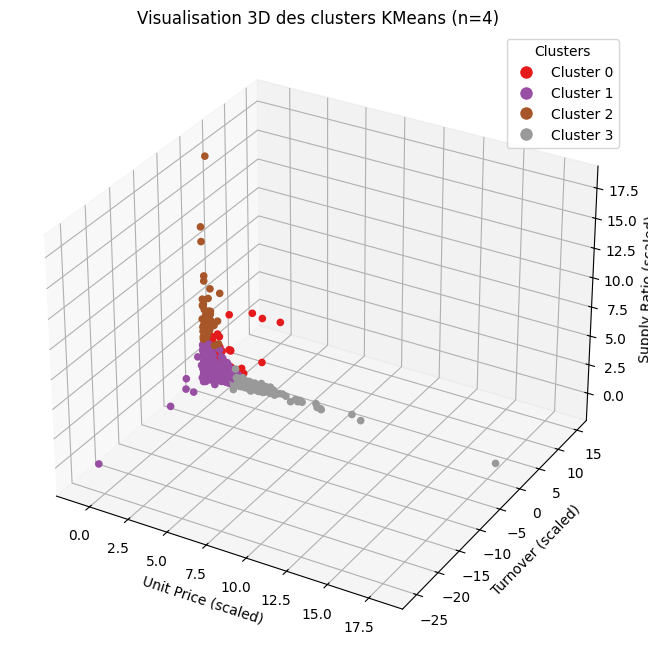

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X2_scaled[:, 0],  # UnitPrice
    X2_scaled[:, 1],  # Turnover
    X2_scaled[:, 2],  # SupplyRatio
    c=P2['KM2_Cluster'], cmap='Set1', alpha=1
)

ax.set_xlabel('Unit Price (scaled)')
ax.set_ylabel('Turnover (scaled)')
ax.set_zlabel('Supply Ratio (scaled)')

plt.title('Visualisation 3D des clusters KMeans (n=4)')

# Ajout de la légende des clusters
cluster_labels = sorted(P2['KM2_Cluster'].unique())
colors = [plt.cm.Set1(i / max(cluster_labels)) for i in cluster_labels]
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'Cluster {cl}',
           markerfacecolor=col, markersize=10)
    for cl, col in zip(cluster_labels, colors)
]
ax.legend(handles=legend_elements, title="Clusters")

plt.show()

**Résultats**

In [ ]:
ResultCluster1 = P2[['Name', 'Moves', 'QtIn', 'QtOut', 'StockAVG', 'UnitPrice', 'Turnover', 'SupplyRatio', 'KM2_Cluster']].copy()

ResultCluster1 = ResultCluster1[ResultCluster1['KM2_Cluster'] == 2]
ResultCluster1.reset_index(drop=True, inplace=True)
ResultCluster1.sort_values(by='Turnover', ascending=True, inplace=True)

In [ ]:
P2[['Moves', 'QtIn', 'QtOut', 'StockAVG', 'UnitPrice', 'Turnover', 'SupplyRatio']].describe()

,Moves,QtIn,QtOut,StockAVG,UnitPrice,Turnover,SupplyRatio
count,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000,2038.000000
mean,262.866045,380.655054,378.628557,4.917013,32763.057630,59.343683,1.088709
std,488.759703,1183.374358,1183.172689,12.457151,41307.459552,94.910952,1.050142
min,1.000000,0.000000,-0.000000,-50.152482,200.000000,-2343.500000,0.000000
25%,40.000000,30.000000,27.250000,1.098149,10025.000000,21.333333,0.630721
50%,129.000000,106.000000,104.500000,2.052294,20800.000000,47.898961,0.828888
75%,295.000000,303.500000,303.750000,4.327022,40500.000000,84.071663,1.083333
max,7578.000000,25862.000000,25885.000000,288.034084,782000.000000,1449.363636,19.913108


In [ ]:
ResultCluster1[['Moves', 'QtIn', 'QtOut', 'StockAVG', 'UnitPrice', 'Turnover', 'SupplyRatio']].describe()

,Moves,QtIn,QtOut,StockAVG,UnitPrice,Turnover,SupplyRatio
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,428.352941,2585.039216,2585.784314,36.415303,3944.282467,78.868700,6.016767
std,605.657158,3728.121478,3750.965936,49.012353,8455.493937,82.023530,2.861842
min,2.000000,10.000000,6.000000,-50.152482,200.000000,-23.149403,3.492537
25%,86.500000,419.000000,398.000000,9.674720,750.000000,15.522352,4.524749
50%,226.000000,1062.000000,1161.000000,20.505747,1300.000000,48.658993,5.093023
75%,504.500000,2667.500000,2677.000000,53.754326,2400.000000,118.315472,6.612548
max,2904.000000,15609.000000,15737.000000,288.034084,44400.000000,380.679366,19.913108


In [ ]:
ResultCluster1.head(10)

,Name,Moves,QtIn,QtOut,StockAVG,UnitPrice,Turnover,SupplyRatio,KM2_Cluster
34,GEL MAINS HYDROALCOOLIQUE FL/1L ABONDANCE,282,1052.0,1161.0,-50.152482,36600.000000,-23.149403,3.730496,2
50,SILYBON 140MG CP DET PL/10 MICROLABS,6,30.0,6.0,-1.333333,15679.202901,-4.500000,5.000000,2
43,GLONOX 400MG CP B/10*10 GLOBAL PHARMA,2,10.0,10.0,5.000000,5100.000000,2.000000,5.000000,2
35,RIZIDE 80MG CP DET SUNRISE,8,40.0,40.0,11.750000,2100.000000,3.404255,5.000000,2
39,LAME A BISTOURIE N 11 DET,35,200.0,200.0,54.114286,600.000000,3.695882,5.714286,2
37,HCQS HYDROXYCHLOROQUINE SULFATE 200MG CP PELLI...,71,273.0,313.0,53.394366,44400.000000,5.862042,3.845070,2
40,"CHLORURE DE POTASSIUM PROAMP AGUETTANT 0,10G/M...",120,550.0,522.0,57.908333,1500.000000,9.014247,4.583333,2
48,IMMUN ACTIVE + D3 DENK DET,14,80.0,80.0,7.714286,3100.000000,10.370370,5.714286,2
47,LAME A BISTOURIE N 12 DET,57,800.0,706.0,67.421053,400.000000,10.471507,14.035088,2
49,ALDACARE 400MG CP DET B/1 M&S CARE,96,400.0,306.0,26.208333,10879.202901,11.675676,4.166667,2


In [ ]:
ResultCluster1.tail(10)

,Name,Moves,QtIn,QtOut,StockAVG,UnitPrice,Turnover,SupplyRatio,KM2_Cluster
29,YENDOL SACH DET,364,1522.0,1498.0,10.406593,2200.0,143.947202,4.181319,2
26,TIORFAN 10MG NN SACH DET BIOPROJET,351,1523.0,1521.0,10.262108,2000.0,148.215158,4.339031,2
31,IMMUN ACTIVE DENK DET,526,3068.0,3074.0,19.982890,2600.0,153.831605,5.832700,2
20,PHYSIODOSE UNIDOSE SERUM PHYSIOLOGIQUE UNIDOSE...,1168,6468.0,6508.0,37.203767,800.0,174.928522,5.537671,2
12,ERY 250MG SACH DET BOUCHARA,212,1674.0,1759.0,9.957547,1300.0,176.649929,7.896226,2
27,TIORFAN 30MG ENF SACH DET BIOPROJET,259,1507.0,1484.0,8.293436,1100.0,178.936685,5.818533,2
24,SMECTA 3G SACH DET IPSEN,2519,11978.0,12056.0,65.732434,1200.0,183.410219,4.755062,2
3,ANTHEL 400MG CP DET B/1 LINCOLN,2904,12414.0,12441.0,50.071970,1200.0,248.462365,4.274793,2
44,FORCE G BOOSTER SHOT BIO DET VITAVEA,192,870.0,852.0,2.843750,4600.0,299.604396,4.531250,2
16,MAGNES DENK DIRECT STICKS DET DENK PHARMA,1254,8518.0,8558.0,22.480861,1700.0,380.679366,6.792663,2


### Evaluation financière des résultats

In [ ]:
finance = ResultCluster1.copy()
finance['PurchasePrice'] = finance['UnitPrice']/(1+0.26)
finance['AmountEuro'] = finance['PurchasePrice'] * finance['StockAVG']/5000


In [ ]:
finance.head()

,Name,Moves,QtIn,QtOut,StockAVG,UnitPrice,Turnover,SupplyRatio,KM2_Cluster,PurchasePrice,AmountEuro
34,GEL MAINS HYDROALCOOLIQUE FL/1L ABONDANCE,282,1052.0,1161.0,-50.152482,36600.000000,-23.149403,3.730496,2,29047.619048,-291.362040
50,SILYBON 140MG CP DET PL/10 MICROLABS,6,30.0,6.0,-1.333333,15679.202901,-4.500000,5.000000,2,12443.811826,-3.318350
43,GLONOX 400MG CP B/10*10 GLOBAL PHARMA,2,10.0,10.0,5.000000,5100.000000,2.000000,5.000000,2,4047.619048,4.047619
35,RIZIDE 80MG CP DET SUNRISE,8,40.0,40.0,11.750000,2100.000000,3.404255,5.000000,2,1666.666667,3.916667
39,LAME A BISTOURIE N 11 DET,35,200.0,200.0,54.114286,600.000000,3.695882,5.714286,2,476.190476,5.153741


In [ ]:
finance['AmountEuro'].sum()

582.0547992406364

In [ ]:
finance2 = P2[(P2['KM2_Cluster'] == 1) & (P2['Turnover'] < 10)].copy()
finance2.reset_index(drop=True, inplace=True)
finance2.shape

(228, 10)

In [ ]:
finance2['PurchasePrice'] = finance2['UnitPrice']/(1.26)
finance2['AmountEuro'] = finance2['PurchasePrice'] * finance2['StockAVG']/5000
finance2.head()

,ProdId,Name,Moves,QtIn,QtOut,StockAVG,UnitPrice,Turnover,SupplyRatio,KM2_Cluster,PurchasePrice,AmountEuro
0,106,A 313 50000U CAPS B/30,13,8.0,8.0,0.846154,20800.0,9.454545,0.615385,1,16507.936508,2.793651
1,135,C,2,1.0,1.0,0.500000,56200.0,2.000000,0.500000,1,44603.174603,4.460317
2,181,BOUILLOTE 2L FAZ,14,9.0,8.0,0.857143,61600.0,9.333333,0.642857,1,48888.888889,8.380952
3,273,AMOXICILLINE 500MG GELU DET PL/10 ARROW,56,69.0,69.0,-2.267857,4300.0,-30.425197,1.232143,1,3412.698413,-1.547902
4,326,ANTITHYROX 5MG CP PELL B/30 MACLEODS,11,10.0,10.0,1.363636,23100.0,7.333333,0.909091,1,18333.333333,5.000000


In [ ]:
finance2['AmountEuro'].sum()

1351.684224153647

In [ ]:
finance3 =  P2[(P2['KM2_Cluster'] == 3) & (P2['Turnover'] < 5)].copy()
finance3.reset_index(drop=True, inplace=True)
finance3.shape

(14, 10)

In [ ]:
finance3['PurchasePrice'] = finance3['UnitPrice']/(1.26)
finance3['AmountEuro'] = finance3['PurchasePrice'] * finance3['StockAVG']/5000
finance3.head()

,ProdId,Name,Moves,QtIn,QtOut,StockAVG,UnitPrice,Turnover,SupplyRatio,KM2_Cluster,PurchasePrice,AmountEuro
0,785,BIODERMA WHITE OBJECTIVE SERUM FL/30ML,2,1.0,1.0,0.5,127900.0,2.00,0.5,3,101507.936508,10.150794
1,1359,CREON 25000U GELU B/60 SOLVAY,5,3.0,3.0,0.8,145600.0,3.75,0.6,3,115555.555556,18.488889
2,3277,NICARDIPINE AGUETTANT AMP INJ 10MG/10ML B/10 F...,2,1.0,1.0,0.0,84700.0,0.00,0.5,3,67222.222222,0.000000
3,3279,NICORETTE 2MG GOMMES CLASSIC SANS SUCRE B/105,2,1.0,1.0,0.5,126100.0,2.00,0.5,3,100079.365079,10.007937
4,4732,URIAGE BARIESUN BRUME SECHE SPRAY SPF 50+ FL/2...,2,1.0,1.0,0.5,88700.0,2.00,0.5,3,70396.825397,7.039683


In [ ]:
finance3.describe()

,ProdId,Moves,QtIn,QtOut,StockAVG,UnitPrice,Turnover,SupplyRatio,KM2_Cluster,PurchasePrice,AmountEuro
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.0,14.000000,14.000000
mean,5529.071429,4.000000,2.500000,1.857143,0.391868,200528.571429,-5.632764,0.690043,3.0,159149.659864,5.098108
std,2399.440238,3.782551,2.244652,1.915810,0.655708,184813.645969,26.652447,0.403025,0.0,146677.496801,23.820568
min,785.000000,1.000000,1.000000,-0.000000,-0.500000,84700.000000,-98.000000,0.500000,3.0,67222.222222,-62.063492
25%,3642.250000,2.000000,1.000000,1.000000,0.000000,101325.000000,0.000000,0.500000,3.0,80416.666667,0.000000
50%,7009.000000,2.500000,2.000000,1.000000,0.416667,127000.000000,2.000000,0.500000,3.0,100793.650794,9.575397
75%,7207.000000,3.750000,2.750000,1.750000,0.500000,219450.000000,2.847826,0.666667,3.0,174166.666667,16.829365
max,7771.000000,14.000000,8.000000,7.000000,2.090909,782000.000000,4.000000,2.000000,3.0,620634.920635,41.121212


In [ ]:
finance3[finance3['StockAVG'] > 0]['AmountEuro'].sum()

153.6921115921116